# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

## Problem Statement

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

| Gesture | Corresponding Action |
| :---: | :---: | 
| Thumbs up | Increase the volume |
| Thumbs down | Decrease the volume |
| Left swipe | 'Jump' backwards 10 seconds |
| Right swipe | 'Jump' forward 10 seconds   |
| Stop | Pause the movie |

Each video is a sequence of 30 frames (or images).

<b>Objectives:

1. <b>Generator</b>:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. <b>Model</b>: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. <b>Write up</b>: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 


In [1]:
# importing necessary libraries

import numpy as np
import os
import imageio
import datetime
import os
from skimage.transform import resize
from imageio import imread
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
project_folder='datasets/Project_data'

In [4]:
train_doc = np.random.permutation(open(project_folder + '/train.csv').readlines())
val_doc = np.random.permutation(open(project_folder+'/val.csv').readlines())
batch_size = 64

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
# creating few of common methods to be used in generator

# normalize the image
def normalize(image):
    return image/255.0

# crop the image, since the images are in different size 
def crop(image, y, z):
    h, w = image.shape
    # Crop the smaller image at the center to a size of 120x120 pixels.
    if w == 160:
        image = image[:120, 20:140]     
    # resize every image
    return resize(image, (y,z))

# method to normalize and crop the image
def process(image, y, z):
    return normalize(crop(image, y, z))

In [8]:
# externalizing the get batch code into a method and passing image tensor as part of extra paramter in the method
def getData(source_path, t, batch, batch_size, img_tensor):
    [x,y,z] = [len(img_tensor[0]),img_tensor[1], img_tensor[2]]
    img_idx = img_tensor[0]
    batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes

            # separate preprocessImage function is defined for cropping, resizing and normalizing images
            batch_data[folder,idx,:,:,0] = process(image[:, :, 0], y, z)
            batch_data[folder,idx,:,:,1] = process(image[:, :, 1], y, z)
            batch_data[folder,idx,:,:,2] = process(image[:, :, 2], y, z)

        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    return batch_data, batch_labels  #you yield the batch_data and the batch_labels, remember what does yield do

In [9]:
def generator(source_path, folder_list, batch_size, img_tensor):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            yield getData(source_path, t, batch, batch_size, img_tensor)
        
        # write the code for the remaining data points which are left after full batches
        # checking if any remaining batches are there or not
        if len(folder_list)%batch_size != 0:
            # updated the batch size and yield
            batch_size = len(folder_list)%batch_size
            yield getData(source_path, t, batch, batch_size, img_tensor)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [10]:
curr_dt_time = datetime.datetime.now()
train_path = project_folder+'/train'
val_path = project_folder+'/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 1 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 1


In [11]:
def getImgageTensor(n_frames):
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
    return [img_idx, 100, 100, 3]

# define image tensor size
img_tensor = getImgageTensor(30)
print ('# img_tensor =', img_tensor)

# img_tensor = [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), 100, 100, 3]


In [12]:
# retrieve record from train generator
sample_generator = generator(train_path, train_doc, batch_size, img_tensor)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# retrieve record from validation generator
sample_val_generator = generator(val_path, val_doc, batch_size, img_tensor)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

Source path =  datasets/Project_data/train ; batch size = 64
(64, 30, 100, 100, 3)
Source path =  datasets/Project_data/val ; batch size = 64
(64, 30, 100, 100, 3)


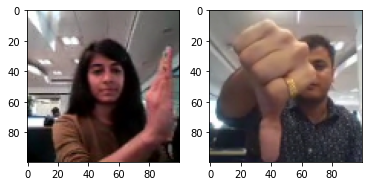

In [11]:
# plot generated sample images
fig, ax = plt.subplots(1,2)
ax[0].imshow(sample_val_batch_data[16,10,:,:,:])   
ax[1].imshow(sample_val_batch_data[25,10,:,:,:])
plt.show()

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [25]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2

#write the model here

# creating the base model definition as a python function, which can be reused in later state
def createModel(img_tensor):
    input_shape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])
    return Sequential([
        Conv3D(16, kernel_size=(3,3,3), activation='relu', input_shape=input_shape),
        MaxPooling3D(pool_size=(2,2,2), padding='same'),
        BatchNormalization(),

        Conv3D(32, kernel_size=(3,3,3), activation='relu'),
        MaxPooling3D(pool_size=(2,2,2), padding='same'),
        BatchNormalization(),

        Conv3D(64, kernel_size=(3,3,3), activation='relu'),
        MaxPooling3D(pool_size=(2,2,2), padding='same'),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(5, activation='softmax')
    ])

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [13]:
model = createModel(img_tensor)
optimiser = tf.keras.optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 28, 98, 98, 16)    1312      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 14, 49, 49, 16)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 49, 49, 16)   64        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 12, 47, 47, 32)    13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 6, 24, 24, 32)    0         
 3D)                                                             
                                                        

2024-08-03 01:59:56.611010: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-08-03 01:59:56.611089: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [14]:
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

In [15]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.m

In [16]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [17]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 64


2024-08-03 02:00:24.626326: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


11/11 [==============================] - ETA: 0s - loss: 1.4618 - categorical_accuracy: 0.4781 Source path =  datasets/Project_data/val ; batch size = 64

Epoch 00001: saving model to model_init_2024-08-0301_59_18.099344/model-00001-1.46184-0.47813-1.98243-0.24000.h5
11/11 [==============================] - 186s 18s/step - loss: 1.4618 - categorical_accuracy: 0.4781 - val_loss: 1.9824 - val_categorical_accuracy: 0.2400 - lr: 0.0010


### Experimentation 
- We will experiment with different batch_size and frames with minimal number of epochs

In [17]:
# creating method to draw training accuracy vs validation accuracy
def drawModelHistory(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(history.history['loss'])   
    ax[0].plot(history.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Training loss vs Validation loss")

    ax[1].plot(history.history['categorical_accuracy'])   
    ax[1].plot(history.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Training Accuracy vs Validation Accuracy")
    plt.show()

    print("Maximum Training Accuracy", max(history.history['categorical_accuracy']))
    print("Maximum Validaiton Accuracy", max(history.history['val_categorical_accuracy']))

In [19]:
def runModel(batch_size, n_frames, num_epochs):
    
    img_tensor = getImgageTensor(n_frames)   
    
    train_generator = generator(train_path, train_doc, batch_size, img_tensor)
    val_generator = generator(val_path, val_doc, batch_size, img_tensor)
    
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    model = createModel(img_tensor)
    optimiser = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())
 
    return model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

### Experiment
- In this process we will understand the model training imapct with different parameter

In [20]:
# Test 1
# batch_size : 20
# n_frames : 30 
# num_epochs: 2
model = runModel(20, 30, 2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 28, 98, 98, 16)    1312      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 14, 49, 49, 16)   0         
 3D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 14, 49, 49, 16)   64        
 hNormalization)                                                 
                                                                 
 conv3d_4 (Conv3D)           (None, 12, 47, 47, 32)    13856     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 6, 24, 24, 32)    0         
 3D)                                                             
                                                      

In [21]:
# Test 2
# batch_size : 15
# n_frames : 30
# num_epochs: 2
runModel(15, 20, 2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 18, 98, 98, 16)    1312      
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 9, 49, 49, 16)    0         
 3D)                                                             
                                                                 
 batch_normalization_10 (Bat  (None, 9, 49, 49, 16)    64        
 chNormalization)                                                
                                                                 
 conv3d_7 (Conv3D)           (None, 7, 47, 47, 32)     13856     
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 4, 24, 24, 32)    0         
 3D)                                                             
                                                      

In [22]:
# Test 3
# batch_size : 30
# n_frames : 16
# num_epochs: 2
runModel(30, 16, 2)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 14, 98, 98, 16)    1312      
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 7, 49, 49, 16)    0         
 3D)                                                             
                                                                 
 batch_normalization_15 (Bat  (None, 7, 49, 49, 16)    64        
 chNormalization)                                                
                                                                 
 conv3d_10 (Conv3D)          (None, 5, 47, 47, 32)     13856     
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 3, 24, 24, 32)    0         
 g3D)                                                            
                                                      

- Number of frames in sequence and batch_size has impact on model training
- We will experiment on different frame size and batch size and will change the base model as needed

### Model 1
- batch_size: 40
- n_frames: 20
- num_epochs: 20

In [23]:
model1_history = runModel(batch_size=40, n_frames=20, num_epochs=20)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 18, 98, 98, 16)    1312      
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 9, 49, 49, 16)    0         
 g3D)                                                            
                                                                 
 batch_normalization_20 (Bat  (None, 9, 49, 49, 16)    64        
 chNormalization)                                                
                                                                 
 conv3d_13 (Conv3D)          (None, 7, 47, 47, 32)     13856     
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 4, 24, 24, 32)    0         
 g3D)                                                            
                                                      

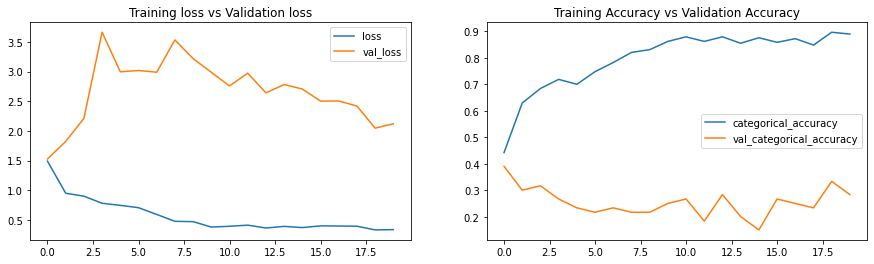

Maximum Training Accuracy 0.8961937427520752
Maximum Validaiton Accuracy 0.38999998569488525


In [24]:
drawModelHistory(model1_history)

- The above model is clearly overfitting

### Model 2
- Frames: 20
- Epoch: 25
- batch_size: 20
- changing dropout : 0.5

In [25]:
n_frames = 20
num_epochs = 25 
batch_size = 20
dropout = 0.5

img_tensor = getImgageTensor(n_frames)   
input_shape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

model_exp_3 = Sequential([
    Conv3D(16, kernel_size=(3,3,3), activation='relu', input_shape=input_shape),
    MaxPooling3D(pool_size=(2,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(32, kernel_size=(3,3,3), activation='relu'),
    MaxPooling3D(pool_size=(2,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, kernel_size=(3,3,3), activation='relu'),
    MaxPooling3D(pool_size=(2,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(dropout),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(dropout),

    Dense(5, activation='softmax')
])

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


optimiser = tf.keras.optimizers.Adam()
model_exp_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_exp_3.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 18, 98, 98, 16)    1312      
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 9, 49, 49, 16)    0         
 g3D)                                                            
                                                                 
 batch_normalization_25 (Bat  (None, 9, 49, 49, 16)    64        
 chNormalization)                                                
                                                                 
 conv3d_16 (Conv3D)          (None, 7, 47, 47, 32)     13856     
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 4, 24, 24, 32)    0         
 g3D)                                                            
                                                      

In [27]:
# run the above experimentation
history_model2 = model_exp_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
        callbacks=callbacks_list, validation_data=val_generator, 
        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.8404 - categorical_accuracy: 0.3665Source path =  datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2024-08-0301_59_18.099344/model-00001-1.84041-0.36652-2.28664-0.19000.h5
34/34 [==============================] - 127s 4s/step - loss: 1.8404 - categorical_accuracy: 0.3665 - val_loss: 2.2866 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 2.1160 - categorical_accuracy: 0.3529
Epoch 00002: saving model to model_init_2024-08-0301_59_18.099344/model-00002-2.11604-0.35294-2.03908-0.19000.h5
34/34 [==============================] - 37s 1s/step - loss: 2.1160 - categorical_accuracy: 0.3529 - val_loss: 2.0391 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.9331 - categorical_accuracy: 0.3333
Epo

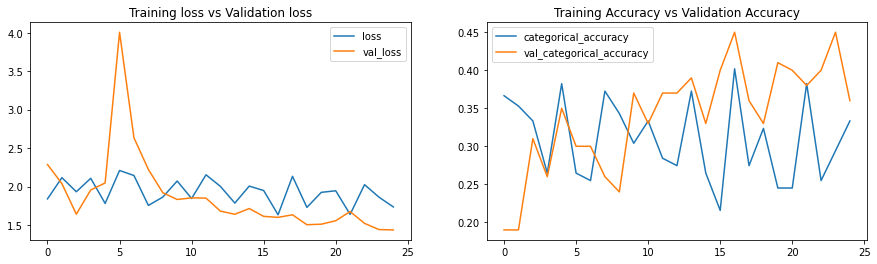

Maximum Training Accuracy 0.4019607901573181
Maximum Validaiton Accuracy 0.44999998807907104


In [28]:
drawModelHistory(history_model2)

- The accuracy has been reduced

### Model 3
- Frames: 30
- Epoch: 30
- batch_size: 30

In [29]:
n_frames = 30
num_epochs = 30 
batch_size = 30
dropout = 0.5

img_tensor = getImgageTensor(n_frames)   
input_shape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

model_exp_3 = Sequential([
    Conv3D(16, kernel_size=(3,3,3), activation='relu', input_shape=input_shape),
    MaxPooling3D(pool_size=(2,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(32, kernel_size=(3,3,3), activation='relu'),
    MaxPooling3D(pool_size=(2,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, kernel_size=(3,3,3), activation='relu'),
    MaxPooling3D(pool_size=(2,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(dropout),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(dropout),

    Dense(5, activation='softmax')
])

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


optimiser = tf.keras.optimizers.Adam()
model_exp_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_exp_3.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_18 (Conv3D)          (None, 28, 98, 98, 16)    1312      
                                                                 
 max_pooling3d_18 (MaxPoolin  (None, 14, 49, 49, 16)   0         
 g3D)                                                            
                                                                 
 batch_normalization_30 (Bat  (None, 14, 49, 49, 16)   64        
 chNormalization)                                                
                                                                 
 conv3d_19 (Conv3D)          (None, 12, 47, 47, 32)    13856     
                                                                 
 max_pooling3d_19 (MaxPoolin  (None, 6, 24, 24, 32)    0         
 g3D)                                                            
                                                      

In [30]:
model_history_exp3 = model_exp_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.9745 - categorical_accuracy: 0.3952Source path =  datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2024-08-0301_59_18.099344/model-00001-1.97449-0.39517-2.24289-0.16000.h5
23/23 [==============================] - 186s 8s/step - loss: 1.9745 - categorical_accuracy: 0.3952 - val_loss: 2.2429 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 2.2803 - categorical_accuracy: 0.2609
Epoch 00002: saving model to model_init_2024-08-0301_59_18.099344/model-00002-2.28028-0.26087-4.48257-0.30000.h5
23/23 [==============================] - 30s 1s/step - loss: 2.2803 - categorical_accuracy: 0.2609 - val_loss: 4.4826 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 2.2604 - categorical_accuracy: 0.3043
Epo

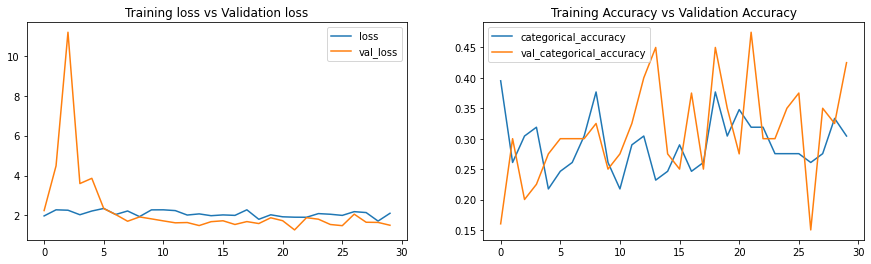

Maximum Training Accuracy 0.39517346024513245
Maximum Validaiton Accuracy 0.4749999940395355


In [31]:
drawModelHistory(model_history_exp3)

<b>Observation
- The above model is underfitting
- The accuracy is not great

### Model 4
- Frames: 30
- Epoch: 30
- batch_size: 64
- dropout: 0.25

In [33]:
n_frames = 30
num_epochs = 30 
batch_size = 64
dropout = 0.25

img_tensor = getImgageTensor(n_frames)   
input_shape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

model_exp_4 = Sequential([
    Conv3D(16, kernel_size=(3,3,3), activation='relu', input_shape=input_shape),
    MaxPooling3D(pool_size=(2,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(32, kernel_size=(3,3,3), activation='relu'),
    MaxPooling3D(pool_size=(2,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, kernel_size=(3,3,3), activation='relu'),
    MaxPooling3D(pool_size=(2,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(dropout),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(dropout),

    Dense(5, activation='softmax')
])

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


optimiser = tf.keras.optimizers.Adam()
model_exp_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_exp_4.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_21 (Conv3D)          (None, 28, 98, 98, 16)    1312      
                                                                 
 max_pooling3d_21 (MaxPoolin  (None, 14, 49, 49, 16)   0         
 g3D)                                                            
                                                                 
 batch_normalization_35 (Bat  (None, 14, 49, 49, 16)   64        
 chNormalization)                                                
                                                                 
 conv3d_22 (Conv3D)          (None, 12, 47, 47, 32)    13856     
                                                                 
 max_pooling3d_22 (MaxPoolin  (None, 6, 24, 24, 32)    0         
 g3D)                                                            
                                                      

In [35]:
model_history_exp4 = model_exp_4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 0.4503 - categorical_accuracy: 0.8396
Epoch 00001: saving model to model_init_2024-08-0301_59_18.099344/model-00001-0.45032-0.83957-1.35549-0.50000.h5
11/11 [==============================] - 48s 5s/step - loss: 0.4503 - categorical_accuracy: 0.8396 - val_loss: 1.3555 - val_categorical_accuracy: 0.5000 - lr: 6.4000e-08
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 0.4132 - categorical_accuracy: 0.8610
Epoch 00002: saving model to model_init_2024-08-0301_59_18.099344/model-00002-0.41317-0.86096-1.87805-0.37500.h5
11/11 [==============================] - 47s 5s/step - loss: 0.4132 - categorical_accuracy: 0.8610 - val_loss: 1.8780 - val_categorical_accuracy: 0.3750 - lr: 6.4000e-08
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 0.3896 - categorical_accuracy: 0.8770
Epoch 00003: saving model to model_init_2024-08-0301_59_18.099344/model-00003-0.38959-0.87701-2.62763-0.25000.h5
11/

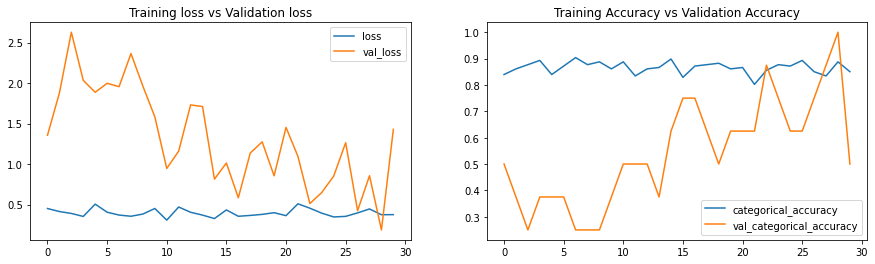

Maximum Training Accuracy 0.903743326663971
Maximum Validaiton Accuracy 1.0


In [36]:
drawModelHistory(model_history_exp4)

- The model is underfitting

### Model 5
- using dropout at each conv layer and reducing batch size
 - Frames: 30
 - Epoch: 30
 - batch_size: 40

In [39]:
n_frames = 30
n_frames = 30
num_epochs = 30 
batch_size = 40
dropout = 0.25

img_tensor = getImgageTensor(n_frames)   
input_shape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

model_exp_5 = Sequential([
    Conv3D(16, kernel_size=(3,3,3), activation='relu', input_shape=input_shape),
    MaxPooling3D(pool_size=(2,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(32, kernel_size=(3,3,3), activation='relu'),
    MaxPooling3D(pool_size=(2,2,2), padding='same'),
    BatchNormalization(),
    Dropout(dropout),

    Conv3D(64, kernel_size=(3,3,3), activation='relu'),
    MaxPooling3D(pool_size=(2,2,2), padding='same'),
    BatchNormalization(),
    Dropout(dropout),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
   
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(dropout),

    Dense(5, activation='softmax')
])

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


optimiser = tf.keras.optimizers.Adam()
model_exp_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_exp_5.summary())


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_27 (Conv3D)          (None, 28, 98, 98, 16)    1312      
                                                                 
 max_pooling3d_27 (MaxPoolin  (None, 14, 49, 49, 16)   0         
 g3D)                                                            
                                                                 
 batch_normalization_45 (Bat  (None, 14, 49, 49, 16)   64        
 chNormalization)                                                
                                                                 
 conv3d_28 (Conv3D)          (None, 12, 47, 47, 32)    13856     
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 6, 24, 24, 32)    0         
 g3D)                                                            
                                                      

In [40]:
model_history_exp5 = model_exp_5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 40
Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 1.4118 - categorical_accuracy: 0.4570 Source path =  datasets/Project_data/val ; batch size = 40

Epoch 00001: saving model to model_init_2024-08-0301_59_18.099344/model-00001-1.41176-0.45701-1.51376-0.41000.h5
17/17 [==============================] - 204s 13s/step - loss: 1.4118 - categorical_accuracy: 0.4570 - val_loss: 1.5138 - val_categorical_accuracy: 0.4100 - lr: 0.0010
Epoch 2/30
17/17 [==============================] - ETA: 0s - loss: 0.8524 - categorical_accuracy: 0.6829
Epoch 00002: saving model to model_init_2024-08-0301_59_18.099344/model-00002-0.85240-0.68286-1.62444-0.43333.h5
17/17 [==============================] - 115s 7s/step - loss: 0.8524 - categorical_accuracy: 0.6829 - val_loss: 1.6244 - val_categorical_accuracy: 0.4333 - lr: 0.0010
Epoch 3/30
17/17 [==============================] - ETA: 0s - loss: 0.7500 - categorical_accuracy: 0.7302


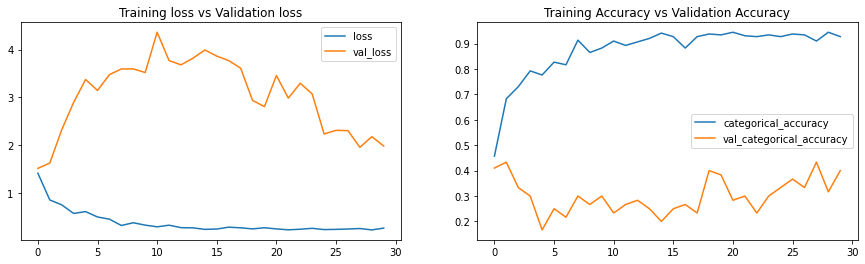

Maximum Training Accuracy 0.9446367025375366
Maximum Validaiton Accuracy 0.4333333373069763


In [41]:
drawModelHistory(model_history_exp5)

- <b>Observation</b>
 - The above model overfitting, so we will fall back with model 4 with reducing batch size and epochs 

### Model 6
 - Frames: 30
 - Epoch: 30
 - batch_size: 40

In [13]:
n_frames = 30
num_epochs = 30 
batch_size = 40
dropout = 0.25

img_tensor = getImgageTensor(n_frames)   
input_shape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

model_exp_6 = Sequential([
    Conv3D(16, kernel_size=(3,3,3), activation='relu', input_shape=input_shape),
    MaxPooling3D(pool_size=(2,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(32, kernel_size=(3,3,3), activation='relu'),
    MaxPooling3D(pool_size=(2,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, kernel_size=(3,3,3), activation='relu'),
    MaxPooling3D(pool_size=(2,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(dropout),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(dropout),

    Dense(5, activation='softmax')
])

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


optimiser = tf.keras.optimizers.Adam()
model_exp_6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_exp_6.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 28, 98, 98, 16)    1312      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 14, 49, 49, 16)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 49, 49, 16)   64        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 12, 47, 47, 32)    13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 6, 24, 24, 32)    0         
 3D)                                                             
                                                        

2024-08-03 05:51:50.115607: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-08-03 05:51:50.115675: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


In [18]:
model_history_exp6 = model_exp_6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 40
Epoch 1/30


2024-08-03 05:53:02.298787: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


17/17 [==============================] - ETA: 0s - loss: 1.6016 - categorical_accuracy: 0.4284Source path =  datasets/Project_data/val ; batch size = 40

Epoch 00001: saving model to model_init_2024-08-0305_50_55.490668/model-00001-1.60161-0.42836-2.27034-0.27000.h5
17/17 [==============================] - 189s 12s/step - loss: 1.6016 - categorical_accuracy: 0.4284 - val_loss: 2.2703 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/30
17/17 [==============================] - ETA: 0s - loss: 0.8879 - categorical_accuracy: 0.6701
Epoch 00002: saving model to model_init_2024-08-0305_50_55.490668/model-00002-0.88786-0.67008-2.26009-0.20000.h5
17/17 [==============================] - 115s 7s/step - loss: 0.8879 - categorical_accuracy: 0.6701 - val_loss: 2.2601 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/30
17/17 [==============================] - ETA: 0s - loss: 0.8409 - categorical_accuracy: 0.6730
Epoch 00003: saving model to model_init_2024-08-0305_50_55.490668/model-0

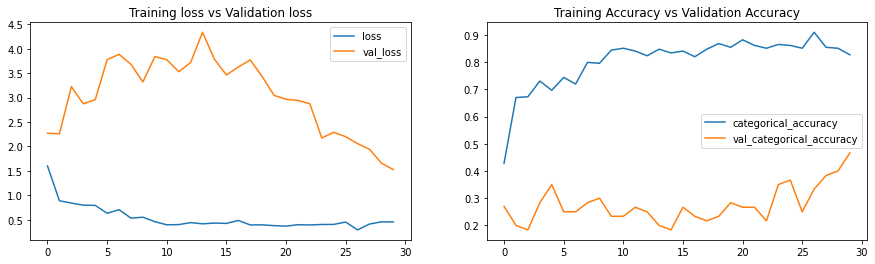

Maximum Training Accuracy 0.9100345969200134
Maximum Validaiton Accuracy 0.46666666865348816


In [20]:
drawModelHistory(model_history_exp6)

### Model 7
 - Frames: 20
 - Epoch: 20
 - batch_size: 64
 - Switching BatchNormalization before MaxPooling with padding same  

In [25]:
n_frames = 20
num_epochs = 20 
batch_size = 64
dropout = 0.25

img_tensor = getImgageTensor(n_frames)   
input_shape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

model_exp_7 = Sequential([
    Conv3D(16, kernel_size=(3,3,3), activation='relu', input_shape=input_shape, padding='same'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2), padding='same'),

    Conv3D(32, kernel_size=(3,3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2), padding='same'),

    Conv3D(64, kernel_size=(3,3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2), padding='same'),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(dropout),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(dropout),

    Dense(5, activation='softmax')
])

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


optimiser = tf.keras.optimizers.Adam()
model_exp_7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_exp_7.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 20, 100, 100, 16)  1312      
                                                                 
 batch_normalization_18 (Bat  (None, 20, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 10, 50, 50, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 10, 50, 50, 32)    13856     
                                                                 
 batch_normalization_19 (Bat  (None, 10, 50, 50, 32)   128       
 chNormalization)                                                
                                                      

In [26]:
model_history_exp7 = model_exp_7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 64
Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 1.4621 - categorical_accuracy: 0.4449 Source path =  datasets/Project_data/val ; batch size = 64

Epoch 00001: saving model to model_init_2024-08-0305_50_55.490668/model-00001-1.46207-0.44495-1.50189-0.29000.h5
11/11 [==============================] - 126s 12s/step - loss: 1.4621 - categorical_accuracy: 0.4449 - val_loss: 1.5019 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 0.8856 - categorical_accuracy: 0.6719
Epoch 00002: saving model to model_init_2024-08-0305_50_55.490668/model-00002-0.88561-0.67194-1.67118-0.40625.h5
11/11 [==============================] - 61s 6s/step - loss: 0.8856 - categorical_accuracy: 0.6719 - val_loss: 1.6712 - val_categorical_accuracy: 0.4062 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 0.8722 - categorical_accuracy: 0.6561
E

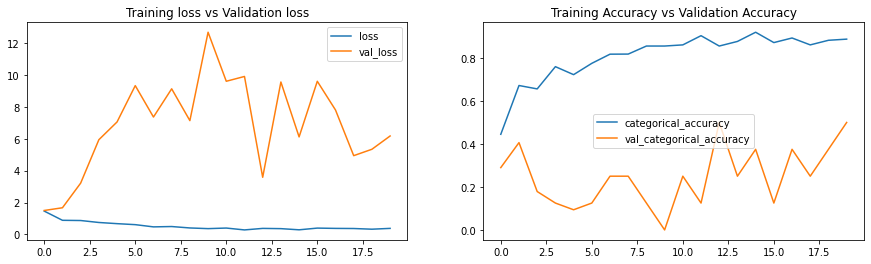

Maximum Training Accuracy 0.9197860956192017
Maximum Validaiton Accuracy 0.5


In [29]:
drawModelHistory(model_history_exp7)

### Model 8
 - Frames: 30
 - Epoch: 30
 - batch_size: 64
 - with different kernels  

In [45]:
n_frames = 30
num_epochs = 30
batch_size = 64

img_tensor = getImgageTensor(n_frames)   
input_shape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

model_exp_8 = Sequential([
    Conv3D(16, (4,4,4), activation='relu', input_shape=input_shape),
    MaxPooling3D((2,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(32, (3,3,3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, (3,3,3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
])

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

optimiser = tf.keras.optimizers.Adam()
model_exp_8.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_exp_8.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 27, 97, 97, 16)    3088      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 14, 49, 49, 16)   0         
 3D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 14, 49, 49, 16)   64        
 hNormalization)                                                 
                                                                 
 conv3d_4 (Conv3D)           (None, 12, 47, 47, 32)    13856     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 12, 24, 24, 32)   0         
 3D)                                                             
                                                      

In [46]:
model_history_exp8 = model_exp_8.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 64
Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 1.5932 - categorical_accuracy: 0.4766 Source path =  datasets/Project_data/val ; batch size = 64

Epoch 00001: saving model to model_init_2024-08-0316_59_35.561493/model-00001-1.59318-0.47662-5.03759-0.26000.h5
11/11 [==============================] - 191s 19s/step - loss: 1.5932 - categorical_accuracy: 0.4766 - val_loss: 5.0376 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 0.8829 - categorical_accuracy: 0.6206
Epoch 00002: saving model to model_init_2024-08-0316_59_35.561493/model-00002-0.88291-0.62055-2.04752-0.21875.h5
11/11 [==============================] - 82s 8s/step - loss: 0.8829 - categorical_accuracy: 0.6206 - val_loss: 2.0475 - val_categorical_accuracy: 0.2188 - lr: 0.0010
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 0.9503 - categorical_accuracy: 0.6759
E

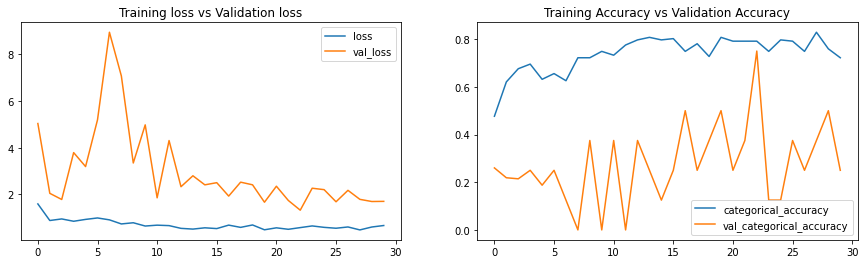

Maximum Training Accuracy 0.8288770318031311
Maximum Validaiton Accuracy 0.75


In [47]:
drawModelHistory(model_history_exp8)

- </b> Final Observation on Conv3D model
    - We played with multiple hyper parameters.
    - Few of models are good candidates for considerataion, requires furthure tuning to reduce overfitting. 
    - We have seen in Conv3D the trainable parameters are much higher.
    - Due to time constraint we are stopping here and continuing with Conv2D+LSTM

### Model architecture to Conv2D+LSTM

### Model 1
 - n_frames = 20
 - num_epochs = 30
 - batch_size = 32

In [18]:
n_frames = 20
num_epochs = 30
batch_size = 32

img_tensor = getImgageTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

input_shape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model_lstm = Sequential([
    TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'), input_shape=input_shape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),

    TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),

    TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),

    TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),

    TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),

    TimeDistributed(Flatten()),
    LSTM(256),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
])

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

optimiser = tf.keras.optimizers.Adam()
model_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_lstm.summary())

2024-08-04 03:01:41.580854: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-08-04 03:01:41.580919: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 100, 100, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 100, 100, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 50, 50, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 50, 50, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 50, 50, 32)   1

In [19]:
model_lstm_history = model_lstm.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 32
Epoch 1/30


2024-08-04 03:01:52.915771: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.3169 - categorical_accuracy: 0.4344Source path =  datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2024-08-0403_00_48.247162/model-00001-1.31692-0.43439-1.64911-0.23000.h5
21/21 [==============================] - 124s 6s/step - loss: 1.3169 - categorical_accuracy: 0.4344 - val_loss: 1.6491 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.0621 - categorical_accuracy: 0.5880
Epoch 00002: saving model to model_init_2024-08-0403_00_48.247162/model-00002-1.06210-0.58799-1.84569-0.18750.h5
21/21 [==============================] - 78s 4s/step - loss: 1.0621 - categorical_accuracy: 0.5880 - val_loss: 1.8457 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.0128 - categorical_accuracy: 0.5948
Epoch 00003: saving model to model_init_2024-08-0403_00_48.247162/model-000

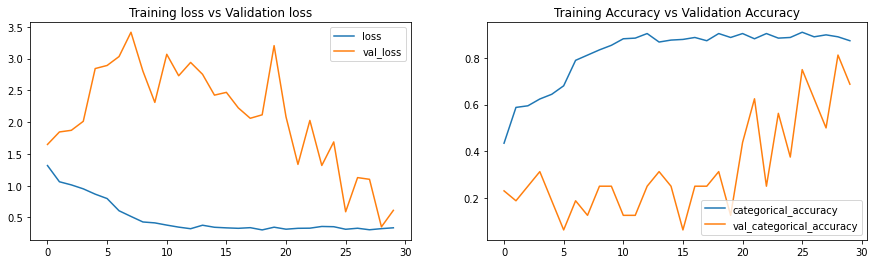

Maximum Training Accuracy 0.9103641510009766
Maximum Validaiton Accuracy 0.8125


In [20]:
drawModelHistory(model_lstm_history)

- </b> Observation
    - The Conv2D, LSTM is overfit a bit
    - We will try with droput in conv layer

### Model 2
- n_frames = 20
- num_epochs = 40
- batch_size = 32
- dropout = 0.2
- adding dropout in conv layer

In [21]:
n_frames = 20
num_epochs = 40
batch_size = 32

img_tensor = getImgageTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

input_shape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model_lstm2 = Sequential([
    TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'), input_shape=input_shape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),

    TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),
    Dropout(0.2),

    TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),

    TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),
    Dropout(0.2),

    TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),

    TimeDistributed(Flatten()),
    LSTM(256),
    Dropout(0.2),

    Dense(256, activation='relu'), 
    Dropout(0.2),

    Dense(5, activation='softmax')
])

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

optimiser = tf.keras.optimizers.Adam()
model_lstm2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_lstm2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 20, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 20, 100, 100, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 20, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 20, 50, 50, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 20, 50, 50, 32)  

In [22]:
model_lstm_history2 = model_lstm2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 32
Epoch 1/40
21/21 [==============================] - ETA: 0s - loss: 1.3696 - categorical_accuracy: 0.4012Source path =  datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2024-08-0403_00_48.247162/model-00001-1.36959-0.40121-1.61800-0.22000.h5
21/21 [==============================] - 122s 6s/step - loss: 1.3696 - categorical_accuracy: 0.4012 - val_loss: 1.6180 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/40
21/21 [==============================] - ETA: 0s - loss: 1.1135 - categorical_accuracy: 0.5569
Epoch 00002: saving model to model_init_2024-08-0403_00_48.247162/model-00002-1.11353-0.55694-2.17750-0.12500.h5
21/21 [==============================] - 78s 4s/step - loss: 1.1135 - categorical_accuracy: 0.5569 - val_loss: 2.1775 - val_categorical_accuracy: 0.1250 - lr: 0.0010
Epoch 3/40
21/21 [==============================] - ETA: 0s - loss: 0.9960 - categorical_accuracy: 0.5808
Epo

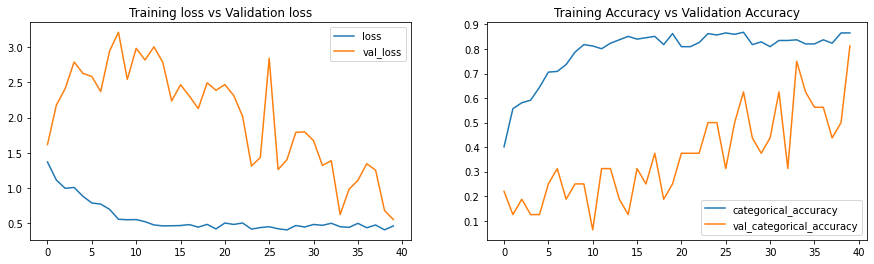

Maximum Training Accuracy 0.8683473467826843
Maximum Validaiton Accuracy 0.8125


In [23]:
drawModelHistory(model_lstm_history2)

### Model 3
- n_frames = 20
- num_epochs = 40
- batch_size = 32
- dropout = 0.2
- adding droput in conv layer
- l2 regularization

In [28]:
n_frames = 20
num_epochs = 40
batch_size = 32

img_tensor = getImgageTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

input_shape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model_lstm3 = Sequential([
    TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'), input_shape=input_shape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),

    TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),
    Dropout(0.2),

    TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),

    TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),
    Dropout(0.2),

    TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),

    TimeDistributed(Flatten()),
    LSTM(256, kernel_regularizer=l2(0.01)),
    Dropout(0.2),

    Dense(256, activation='relu'), 
    Dropout(0.2),

    Dense(5, activation='softmax')
])

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

optimiser = tf.keras.optimizers.Adam()
model_lstm3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_lstm3.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_64 (TimeDi  (None, 20, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_65 (TimeDi  (None, 20, 100, 100, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_66 (TimeDi  (None, 20, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_67 (TimeDi  (None, 20, 50, 50, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_68 (TimeDi  (None, 20, 50, 50, 32)  

In [29]:
model_lstm_history3 = model_lstm3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 32
Epoch 1/40
21/21 [==============================] - ETA: 0s - loss: 11.8888 - categorical_accuracy: 0.3801Source path =  datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2024-08-0403_00_48.247162/model-00001-11.88880-0.38009-8.33324-0.16000.h5
21/21 [==============================] - 126s 6s/step - loss: 11.8888 - categorical_accuracy: 0.3801 - val_loss: 8.3332 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/40
21/21 [==============================] - ETA: 0s - loss: 5.8003 - categorical_accuracy: 0.4741
Epoch 00002: saving model to model_init_2024-08-0403_00_48.247162/model-00002-5.80027-0.47412-5.53199-0.18750.h5
21/21 [==============================] - 80s 4s/step - loss: 5.8003 - categorical_accuracy: 0.4741 - val_loss: 5.5320 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 3/40
21/21 [==============================] - ETA: 0s - loss: 3.4680 - categorical_accuracy: 0.5902


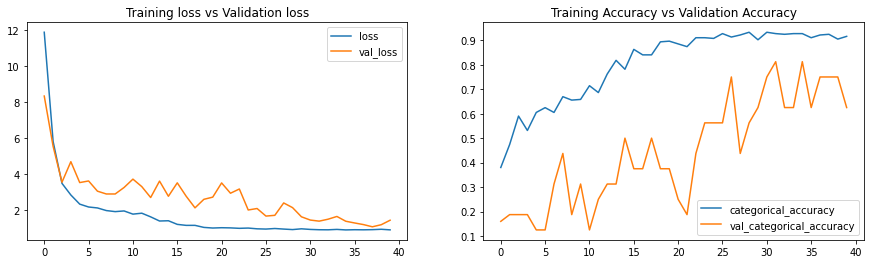

Maximum Training Accuracy 0.9327731132507324
Maximum Validaiton Accuracy 0.8125


In [30]:
drawModelHistory(model_lstm_history3)

### Model 3 (GRU)
- n_frames = 20
- num_epochs = 30
- batch_size = 32
- dropout = 0.5

In [37]:
n_frames = 20
num_epochs = 30
batch_size = 32

img_tensor = getImgageTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

input_shape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model_gru = Sequential([
    TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'), input_shape=input_shape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),

    TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),

    TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),

    TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),

    TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),

    TimeDistributed(Flatten()),
    GRU(256),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
])

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

optimiser = tf.keras.optimizers.Adam()
model_gru.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_gru.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 20, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 20, 100, 100, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 20, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 20, 50, 50, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 20, 50, 50, 32)  

In [38]:
model_gru_history2 = model_gru.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.3903 - categorical_accuracy: 0.4555Source path =  datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2024-08-0310_08_56.907357/model-00001-1.39032-0.45551-1.75701-0.23000.h5
21/21 [==============================] - 135s 7s/step - loss: 1.3903 - categorical_accuracy: 0.4555 - val_loss: 1.7570 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 0.9574 - categorical_accuracy: 0.6335
Epoch 00002: saving model to model_init_2024-08-0310_08_56.907357/model-00002-0.95741-0.63354-2.43551-0.12500.h5
21/21 [==============================] - 83s 4s/step - loss: 0.9574 - categorical_accuracy: 0.6335 - val_loss: 2.4355 - val_categorical_accuracy: 0.1250 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.9378 - categorical_accuracy: 0.6042
Epo

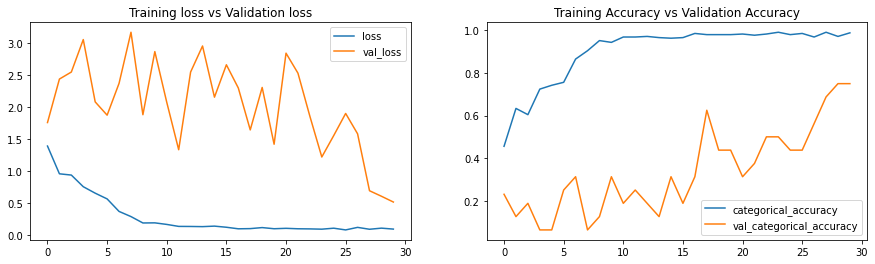

Maximum Training Accuracy 0.9915966391563416
Maximum Validaiton Accuracy 0.75


In [40]:
drawModelHistory(model_gru_history2)